In [36]:
import pandas as pd
import numpy as np
import os
import cv2
import random

import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array

In [37]:
par = './cell_images/Parasitized/'
uninf = './cell_images/Uninfected/'

In [38]:
Parasitized = os.listdir(par)
Uninfected = os.listdir(uninf)

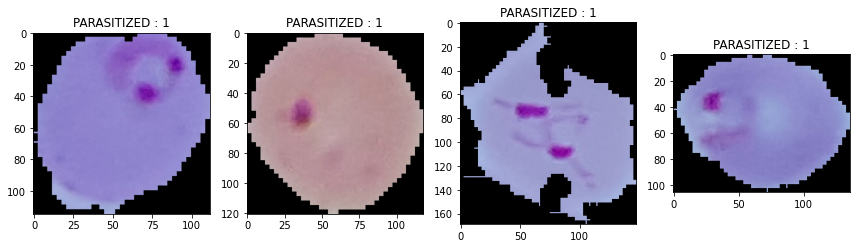

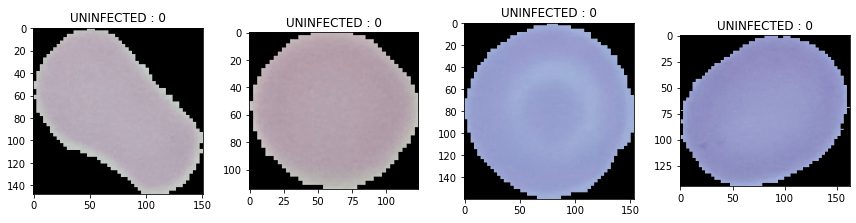

In [40]:
plt.figure(figsize = (12,24))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(par + Parasitized[i])
    plt.imshow(img)
    plt.title('PARASITIZED : 1')
    plt.tight_layout()
plt.show()

plt.figure(figsize = (12,24))
for i in range(4):
    plt.subplot(2, 4, i+1)
    img = cv2.imread(uninf + Uninfected[i+1])
    plt.imshow(img)
    plt.title('UNINFECTED : 0')
    plt.tight_layout()
plt.show()

In [41]:
# Assign Images and Labels into Variables

data = []
labels = []
for img in Parasitized:
    try:
        img_read = plt.imread(par + img)
        img_resize = cv2.resize(img_read, (100, 100))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        None
        
for img in Uninfected:
    try:
        img_read = plt.imread(uninf + img)
        img_resize = cv2.resize(img_read, (100, 100))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

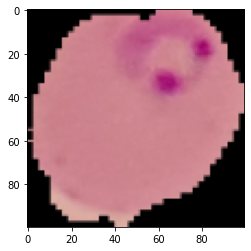

In [43]:
plt.imshow(data[0])
plt.show()

In [44]:
image_data = np.array(data)
labels = np.array(labels)
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [45]:
# Split Data for Train, Test, and Validation

def prep_dataset(X,y):
    X_prep = X.astype('float32')/255
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

In [46]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(image_data,labels, test_size=0.15,
                                          shuffle=True,stratify=labels,random_state=42)
X_ts, X_val, Y_ts, Y_val = train_test_split(X_ts,Y_ts, test_size=0.5, stratify=Y_ts,random_state=42)
X_tr, Y_tr = prep_dataset(X_tr,Y_tr)
X_val, Y_val = prep_dataset(X_val,Y_val)
X_ts, _ = prep_dataset(X_ts,Y_ts)

In [47]:
# Fully Connected Layer

model = models.Sequential()
#Input + Conv 1 + ReLU + Max Pooling
model.add(layers.Conv2D(32,(5,5),activation='relu',padding='same',input_shape=X_tr.shape[1:]))
model.add(layers.MaxPool2D(strides=4))
model.add(layers.BatchNormalization())

# Conv 2 + ReLU + Max Pooling
model.add(layers.Conv2D(64,(5,5),padding='same',activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

# Conv 3 + ReLU + Max Pooling
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

# Conv 4 + ReLU + Max Pooling
model.add(layers.Conv2D(256,(3,3),dilation_rate=(2,2),padding='same',activation='relu'))
model.add(layers.Conv2D(256,(3,3),activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

# Fully Connected + ReLU
model.add(layers.Flatten())
model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dense(100, activation='relu'))

#Output
model.add(layers.Dense(2, activation='softmax'))
model.summary()

2022-11-10 10:45:05.572792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 25, 25, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                        

In [48]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy',mode='max',patience=3,verbose=1)
history= model.fit(X_tr,Y_tr,
                   epochs=20,
                   batch_size=50,
                   validation_data=(X_val,Y_val),
                   callbacks=[es])

Epoch 1/20
469/469 [==============================] - 125s 264ms/step - loss: 0.3020 - accuracy: 0.8650 - val_loss: 1.0064 - val_accuracy: 0.5002
Epoch 2/20
469/469 [==============================] - 115s 245ms/step - loss: 0.1319 - accuracy: 0.9562 - val_loss: 0.1317 - val_accuracy: 0.9574
Epoch 3/20
469/469 [==============================] - 122s 259ms/step - loss: 0.1154 - accuracy: 0.9600 - val_loss: 0.1494 - val_accuracy: 0.9521
Epoch 4/20
469/469 [==============================] - 131s 279ms/step - loss: 0.1091 - accuracy: 0.9626 - val_loss: 0.1228 - val_accuracy: 0.9579
Epoch 5/20
469/469 [==============================] - 127s 270ms/step - loss: 0.1005 - accuracy: 0.9650 - val_loss: 0.1334 - val_accuracy: 0.9579
Epoch 6/20
469/469 [==============================] - 136s 290ms/step - loss: 0.0958 - accuracy: 0.9652 - val_loss: 0.2086 - val_accuracy: 0.9366
Epoch 7/20
469/469 [==============================] - 126s 269ms/step - loss: 0.0901 - accuracy: 0.9693 - val_loss: 0.1342 -

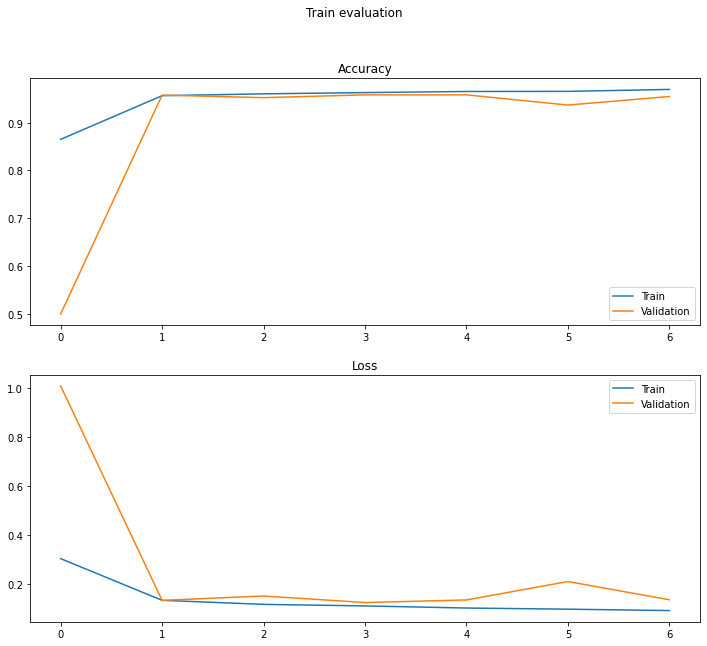

In [50]:
# Evaluation

fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])
ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])
ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
plt.show()

65/65 [==============================] - 4s 57ms/step


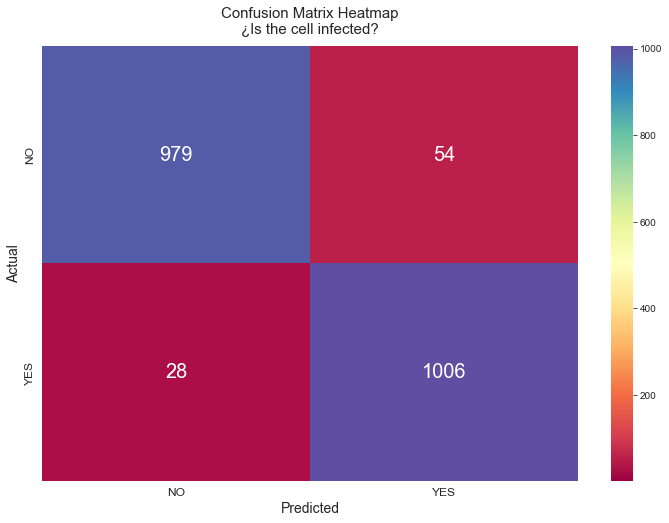

*Acuracy achieved: 96.03%
*Accuracy by model was: 96.93%
*Accuracy by validation was: 95.45%


In [55]:
# More specific insight about the data performance
# Confusion matrix by using Sklearn and predict the output

Y_pred = model.predict(X_ts)
Y_pred = np.argmax(Y_pred, axis=1)
conf_mat = confusion_matrix(Y_ts,Y_pred)
sns.set_style(style='white')
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), 
                      vmax=np.max(conf_mat), annot=True,fmt='d', 
                      annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap\n¿Is the cell infected?', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['NO','YES'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['NO','YES'], fontdict={'fontsize':12})
plt.show()
print('*Acuracy achieved: {:.2f}%\n*Accuracy by model was: {:.2f}%\n*Accuracy by validation was: {:.2f}%'.
       format(accuracy_score(Y_ts,Y_pred)*100,
              (history.history['accuracy'][-1])*100,
              (history.history['val_accuracy'][-1])*100)
     )

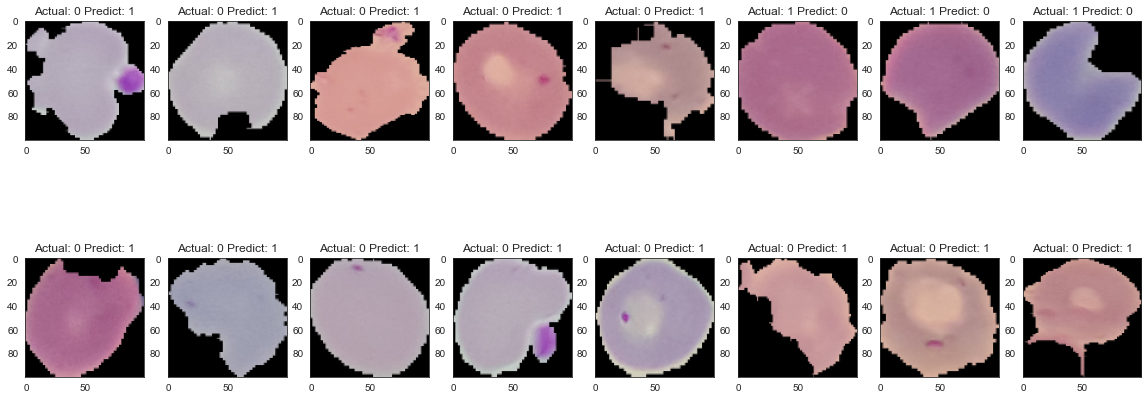

In [52]:
# Error Samples

index=0
index_errors= []
for label, predict in zip(Y_ts,Y_pred):
    if label != predict:
        index_errors.append(index)
    index +=1
plt.figure(figsize=(20,8))
for i,img_index in zip(range(1,17),random.sample(index_errors,k=16)):
    plt.subplot(2,8,i)
    plt.imshow(np.reshape(255*X_ts[img_index], (100,100,3)))
    plt.title('Actual: '+str(Y_ts[img_index])+' Predict: '+str(Y_pred[img_index]))
plt.show()